## Import libraries & set up env for GPU use

In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
import jax
from jax import vmap, jit   
import os
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import (SVI, Trace_ELBO, autoguide, init_to_median, NUTS, MCMC, TraceMeanField_ELBO)
import pandas as pd
import pickle 
from numpyro.infer.util import Predictive, log_density 
import bezier

#%% Environment and/or CUDA commands
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ['XLA_FLAGS']="--xla_gpu_force_compilation_parallelism=1" # This is required until they update some things on PIBE
numpyro.enable_x64(use_x64=True)
path = os.getcwd()
os.chdir(path)

In [2]:
rng_key = random.PRNGKey(0)

""" Import data """
xdata = pd.read_csv('./data/XFOIL_BNN_train.csv',header=None)
ydata = pd.read_csv('./data/XFOIL_BNN_values.csv',header=None)
airfoilName = pd.read_csv('./data/XFOIL_BNN_ref.csv',header=None)
airfoilName = np.array(airfoilName.values.reshape((-1,1)))
x = xdata.values.T
y = ydata.values.T

""" Train-test split depending on the airfoil rather than individual cases (angles) """
def airfoil_train_test_split(X, Y, test_size, random_state, printChoice=False):
    np.random.seed(random_state) 
    airfoilsNum = np.unique(airfoilName).shape[0]
    airfoilsUnique = np.unique(airfoilName).flatten()
    case_indexing = np.arange(0, airfoilsNum) # Create index of unique cases in X 
    test_draws_indexing = np.sort(np.random.choice(case_indexing, size=int(airfoilsNum*test_size)))
    train_draws_indexing = np.sort(np.delete(case_indexing, test_draws_indexing))
    
    if printChoice:
        print(test_draws_indexing)

    for i in range(0, train_draws_indexing.shape[0]):
        ind = np.argwhere(airfoilName.flatten()==airfoilsUnique[train_draws_indexing[i]]).flatten()
        if i == 0:
            x_train = X[ind, :]
            y_train = Y[ind, :]
        else :
            x_train = np.vstack((x_train, X[ind, :]))
            y_train = np.vstack((y_train, Y[ind, :]))
    
    for j in range(0, test_draws_indexing.shape[0]):
        ind2 = np.argwhere(airfoilName.flatten()==airfoilsUnique[test_draws_indexing[j]]).flatten()
        if j == 0:
            x_test = X[ind2, :]
            y_test = Y[ind2, :]
        else :
            x_test = np.vstack((x_test, X[ind2, :]))
            y_test = np.vstack((y_test, Y[ind2, :]))
        
    return x_train, x_test, y_train, y_test 

trainPerc = 0.7 # Split percentage
xTrain, xTest, yTrain, yTest = airfoil_train_test_split(x, y, test_size = 1-trainPerc, random_state=831, printChoice=False)
afTrain, afTest, yTrain, yTest = airfoil_train_test_split(airfoilName, y, test_size = 1-trainPerc, random_state=831)

""" Convert the coordinates data to Bezier fits """
from scipy.optimize import least_squares
def convert_bezier(X, Y, deg):
    degree_af = deg[0]
    degree_p_u = deg[1]
    degree_p_l = deg[2]
    import scipy
    # Convert X to airfoil information
    new_data_x = np.zeros((X.shape[0], 2*(degree_af+2)+1))
    new_data_Cp = np.zeros((X.shape[0], (degree_p_u+2) + (degree_p_l+2))) 
    
        # Create design matrix 
    for i in range(X.shape[0]): # Loop through all cases 
        numVar = 1 # additional variables
        cutoff = int((X.shape[1]-numVar)/2) #  usually 300
        zeroLoc = np.argwhere(np.diff(X[i,:cutoff])<= 0.0)[-1][0]
        # Obtain upper surface
        xc_u = np.flip(X[i, :zeroLoc+1]) # airfoil x, spans from 0 to 1 
        xc_l = X[i, zeroLoc+1:cutoff] 
        yc_u = np.flip(X[i, cutoff:cutoff+zeroLoc+1]) # airfoil thickness
        yc_l = X[i, cutoff+zeroLoc+1:cutoff+cutoff]
        Cp_u = np.flip(Y[i, :zeroLoc+1])
        Cp_l = Y[i, zeroLoc+1:]

        # Set up Bezier obj and optimize the control pts 
        fit_af_upper = bezier.Bezier(xc_u, yc_u, np.ones(degree_af)*np.max(yc_u), 'airfoil') # airfoil upper surf
        fit_af_lower = bezier.Bezier(xc_l, yc_l, np.ones(degree_af)*np.min(yc_l), 'airfoil') # airfoil lower surf
        fit_cp_upper = bezier.Bezier(xc_u, Cp_u, np.ones(degree_p_u)*-1, 'pressure') # pressure upper 
        fit_cp_lower = bezier.Bezier(xc_l, Cp_l, np.ones(degree_p_l)*1, 'pressure') # pressure lower
        least_squares(fit_af_upper.update, np.ones(degree_af)*np.max(yc_u))
        least_squares(fit_af_lower.update, np.ones(degree_af)*np.min(yc_l))
        least_squares(fit_cp_upper.update, np.ones(degree_p_u)*-1)
        least_squares(fit_cp_lower.update, np.ones(degree_p_l)*1)
        
        AoA = X[i, -1]
        new_data_x[i,:] = np.hstack((fit_af_upper.ctrl_pts[:,1].flatten(), fit_af_lower.ctrl_pts[:,1].flatten(), AoA))
        
        new_data_Cp[i,:] = np.hstack((fit_cp_upper.ctrl_pts[:,1].flatten(), fit_cp_lower.ctrl_pts[:,1].flatten()))
        print(i)
    return new_data_x, new_data_Cp, [fit_af_upper.ctrl_pts[:,0], fit_af_lower.ctrl_pts[:,0], fit_cp_upper.ctrl_pts[:,0], fit_cp_lower.ctrl_pts[:,0]]

2024-02-07 22:38:51.749090: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-07 22:38:51.763193: W external/xla/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-02-07 22:38:51.763255: W external/xla/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas


Convert the data

In [3]:
bezier_degs = [8,26,8]
xTrain, yTrain, xTrain_ctrl_pts = convert_bezier(xTrain, yTrain, bezier_degs)
xTest, yTest, xTest_ctrl_pts = convert_bezier(xTest, yTest, bezier_degs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [15]:
file_path = './train_test_bz.pkl'
# with open(file_path, 'wb') as file:
#     save_dict = {'xTrain':xTrain, 'yTrain':yTrain, 'xTrain_ctrl_pts':xTrain_ctrl_pts, 'xTest':xTest, 'yTest':yTest, 'xTest_ctrl_pts':xTest_ctrl_pts}
#     pickle.dump(save_dict, file)

# with open(file_path, 'rb') as file:
#     loaded_data = pickle.load(file)
    
# loaded_data['yTest'].shape

(149, 38)

In [16]:
# Non-linear operation
def nonlin(x):
    return jnp.tanh(x)

# Different model structure - effectively same as the one defined in airfoil_CP_predictor
def model_bnn(X, Y=None, num_Neurons=[300, 300], sigma_w=1):
  D_X, D_Y = X.shape[1], yTrain.shape[1]
  N = X.shape[0]
  # sample first layer (we put unit normal priors on all weights)
  w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, num_Neurons[0])), sigma_w*jnp.ones((D_X, num_Neurons[0]))))  
  b1 = numpyro.sample("b1", dist.Normal(jnp.zeros((num_Neurons[0], 1)), sigma_w*jnp.ones((num_Neurons[0], 1))))
  z1 = nonlin(jnp.matmul(X, w1) + jnp.transpose(b1))   # N D_H  <= first layer of activations

  # sample second layer
  w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((num_Neurons[0], num_Neurons[1])), sigma_w*jnp.ones((num_Neurons[0], num_Neurons[1])))) 
  b2 = numpyro.sample("b2", dist.Normal(jnp.zeros((num_Neurons[1], 1)), sigma_w*jnp.ones((num_Neurons[1], 1))))  # D_H 1
  z2 = nonlin(jnp.matmul(z1, w2) + jnp.transpose(b2))  # N D_H  <= second layer of activations
  
  # w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((num_Neurons[1], num_Neurons[2])), sigma_w*jnp.ones((num_Neurons[1], num_Neurons[2])))) 
  # b3 = numpyro.sample("b3", dist.Normal(jnp.zeros((num_Neurons[2], 1)), sigma_w*jnp.ones((num_Neurons[2], 1))))  # D_H 1
  # z3 = nonlin(jnp.matmul(z2, w3) + jnp.transpose(b3))  # N D_H  <= thrid layer of activations
  
  wf = numpyro.sample("wf", dist.Normal(jnp.zeros((num_Neurons[1], D_Y)), sigma_w*jnp.ones((num_Neurons[1], D_Y)))) 
  bf = numpyro.sample("bf", dist.Normal(jnp.zeros((D_Y, 1)), sigma_w*jnp.ones((D_Y, 1))))  # D_H 1
  zf = jnp.matmul(z2, wf) + jnp.transpose(bf)  # N D_H  <= f layer of activations
 
  with numpyro.plate("obs", N):
    # note we use to_event(1) because each observation has shape (1,)
    numpyro.sample("Y", dist.Normal(zf, 0.02).to_event(1), obs=Y) # 1e-4


## Train model

  0%|          | 0/100000 [00:00<?, ?it/s]2024-02-09 11:25:57.308552: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

100%|██████████| 100000/100000 [00:47<00:00, 2093.07it/s, init loss: 22736320.2330, avg. loss [95001-100000]: 57662.1297]


Text(0, 0.5, 'Loss')

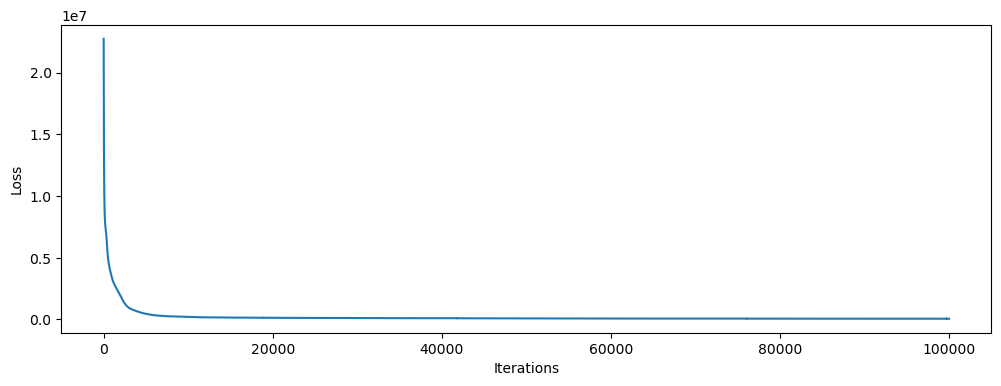

In [137]:
trainNew = True
svi = None
svi_result = None
if trainNew == True:
    # Train new SVI model
    total_iterations = 0
    svi_init_state = None
    guide = autoguide.AutoDelta(model=model_bnn)
    optimizer = numpyro.optim.Adam(step_size = 0.001)
    svi = SVI(model_bnn, guide, optimizer, loss=Trace_ELBO())
elif trainNew == False:
    # Continue the save
    print('Continuing from previous SVI state...') 
    svi.optimizer = numpyro.optim.Adam(step_size = 0.0001)
    svi_init_state = svi_result.state
else:
     raise ValueError('Incorrect input')

n_samples = 10000*10
total_iterations += n_samples
yTrainMean = np.mean(yTrain,axis=0)
svi_result = svi.run(rng_key, n_samples, xTrain, yTrain-yTrainMean, [20, 20], init_state=svi_init_state) 
plt.figure(figsize=(12,4))
plt.plot(svi_result.losses)
plt.xlabel('Iterations')
plt.ylabel('Loss') 

Set up Predictive from the trained model parameters

In [138]:
params = svi_result.params

# get posterior predictive (deterministics and likelihood)
posterior_predictive = Predictive(
    model=model_bnn, guide=guide, params=params, num_samples= 200
)

rng_key, rng_subkey = random.split(key=rng_key)  

## Determining Gaussianity

Text(0.5, 1.0, 'QQ-plot of MLP_draws, 400 samples')

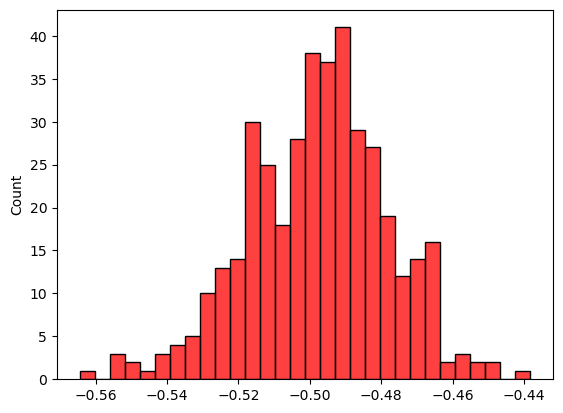

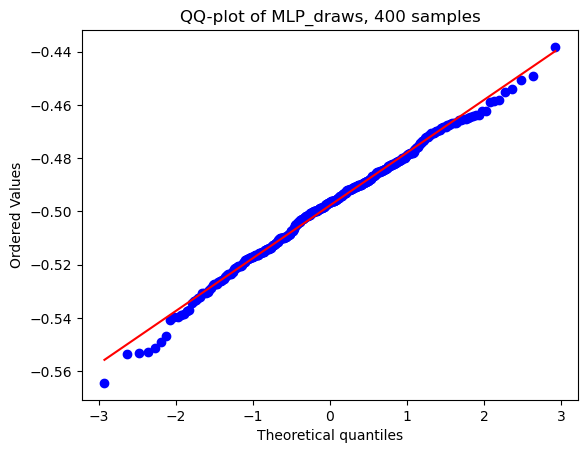

In [101]:
# Samples from the posterior predictive 
numDraws = 400
params = svi_result.params
prediction_sampler = Predictive(
    model=model_bnn, guide=guide, params=params, num_samples= numDraws
)
MLP_draws = np.squeeze(prediction_sampler(rng_key, xTrain[81:82,:])['Y'])
MLP_draws = MLP_draws[:,10]

import seaborn as sns
import scipy
import pylab as py

f = plt.figure()
sns.histplot(MLP_draws.flatten(),color='r', label='True distribution',bins=30)

plt.figure()
scipy.stats.probplot(MLP_draws, dist='norm', plot=py)
plt.title('QQ-plot of MLP_draws, 400 samples')

## Save model params

In [102]:
saveModel = False
if saveModel:
    architecture = 'MLP'
    num_neurons = '300'
    noise_value = 0.02
    additional_notes = 'XFOIL prototype'
    meta = [architecture, num_neurons, noise_value, n_samples, additional_notes]
    data = [xTrain, xTest, afTrain, afTest, yTrain, yTest]
    saveData = [svi_result, guide, data, meta]

    saveData = {} 
    saveData['model'] = model_bnn
    saveData['params'] = svi_result.params
    saveData['guide'] = guide
    saveData['data'] = data
    saveData['meta'] = meta 
# with open('/home/hlee981/Documents/Lift Distribution/Onera M6/Prior Generator Model/quickload.pkl', 'wb') as file:
#         pickle.dump(saveData, file)

## Validation on NACA 4-digit series

Generate predictions and convert to tangible curves - plotting samples, training data

Text(0.5, 0.98, 'Checking predictions on training data')

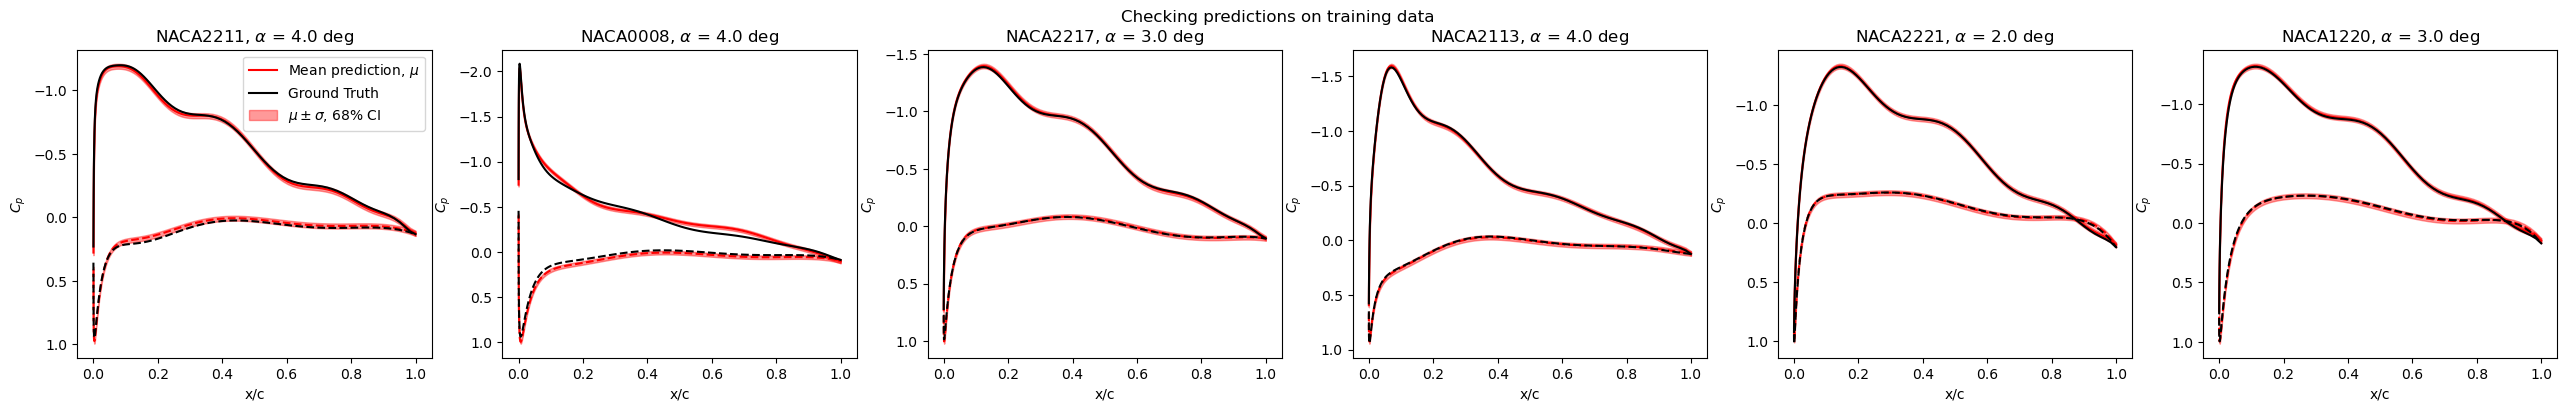

In [181]:
setNew = True
if setNew == True:
    post_pred_train = posterior_predictive(rng_subkey, xTrain)
    mu = np.mean(np.squeeze(post_pred_train['Y']), axis=0) + yTrainMean
    std = np.std(np.squeeze(post_pred_train['Y']), axis=0) # <- CHANGE THIS 

    post_pred_test = posterior_predictive(rng_subkey, xTest)
    mu_t = np.mean(np.squeeze(post_pred_test['Y']), axis=0) + yTrainMean
    std_t = np.std(np.squeeze(post_pred_test['Y']), axis=0)

def verifyCpResults(indRange, og_curve, curve, std_u, std_l, names, ax, subplotInd):
    ax[subplotInd].plot(curve[indRange]['cp_u'][0], curve[indRange]['cp_u'][1] ,'r', label =  'Mean prediction, $\mu$')
    ax[subplotInd].plot(curve[indRange]['cp_l'][0], curve[indRange]['cp_l'][1] ,'r--', label =  '')
    ax[subplotInd].fill_between(std_u[indRange]['cp_u'][0], std_u[indRange]['cp_u'][1], std_l[indRange]['cp_u'][1], color='r', alpha = 0.4, label='$\mu \pm \sigma$, 68% CI')
    ax[subplotInd].fill_between(std_l[indRange]['cp_l'][0], std_u[indRange]['cp_l'][1], std_l[indRange]['cp_l'][1], color='r', alpha = 0.4, label='')
    ax[subplotInd].plot(og_curve[indRange]['cp_u'][0], og_curve[indRange]['cp_u'][1] ,'k', label =  'Ground Truth')
    ax[subplotInd].plot(og_curve[indRange]['cp_l'][0], og_curve[indRange]['cp_l'][1] ,'k--', label =  '')
    ax[subplotInd].invert_yaxis() 
    ax[subplotInd].set_xlabel('x/c')
    ax[subplotInd].set_ylabel('$C_p$')
    titleStr = str(names[indRange][0]) + r", $\alpha$ = " + str(xTrain[indRange,-1]) + ' deg'
    ax[subplotInd].title.set_text(titleStr)

""" Take bezier control point predictions and convert to corresponding curves """
def bezier2curve(x, y, ref_x, num_pts, degrees):
    num_af   = degrees[0] + 2
    num_cp_u = degrees[1] + 2
    num_cp_l = degrees[2] + 2
    xx = np.linspace(0, 1, num_pts)
    
    out_list = [] # create list of dictionaries
    for i in range(0, x.shape[0]): # 
        af_u = bezier.bezier_curve(np.hstack((ref_x[0][:,None], x[i, :num_af][:,None])), xx)
        af_l = bezier.bezier_curve(np.hstack((ref_x[1][:,None], x[i, num_af:-1][:,None])), xx)
        cp_u = bezier.bezier_curve(np.hstack((ref_x[2][:,None], y[i, :num_cp_u][:,None])), xx)
        cp_l = bezier.bezier_curve(np.hstack((ref_x[3][:,None], y[i, num_cp_u:][:,None])), xx)
        caseDict = {'af_u':af_u, 'af_l':af_l, 'cp_u':cp_u, 'cp_l':cp_l}
        out_list.append(caseDict)
        
    return out_list

visualizeSamples = False
if visualizeSamples:
    plt.figure()
    num_samples = 3
    color_u = ['b', 'g', 'm']
    color_l = ['b--', 'g--', 'm--']
    label_u = ['Sample 1', 'Sample 2', 'Sample 3']
    caseIndex = 80
    
    mean_curve = bezier2curve(xTrain[caseIndex, :].reshape((1,-1)), np.mean(np.squeeze(post_pred_train['Y'][:, caseIndex, :]),axis=0).reshape((1,-1)) + yTrainMean, xTest_ctrl_pts, 100, bezier_degs)
    std_curve_u = bezier2curve(xTrain[caseIndex, :].reshape((1,-1)), np.mean(np.squeeze(post_pred_train['Y'][:, caseIndex, :]),axis=0).reshape((1,-1)) + yTrainMean + np.std(np.squeeze(post_pred_train['Y'][:, caseIndex, :]),axis=0).reshape((1,-1)), xTest_ctrl_pts, 100, bezier_degs)
    std_curve_l = bezier2curve(xTrain[caseIndex, :].reshape((1,-1)), np.mean(np.squeeze(post_pred_train['Y'][:, caseIndex, :]),axis=0).reshape((1,-1)) + yTrainMean - np.std(np.squeeze(post_pred_train['Y'][:, caseIndex, :]),axis=0).reshape((1,-1)), xTest_ctrl_pts, 100, bezier_degs)
    plt.plot(mean_curve[0]['cp_u'][0], mean_curve[0]['cp_u'][1], 'r-', label='Mean predicted $C_p$ $\pm \sigma$')
    plt.plot(mean_curve[0]['cp_l'][0], mean_curve[0]['cp_l'][1], 'r--')
    plt.fill_between(std_curve_u[0]['cp_u'][0], std_curve_u[0]['cp_u'][1], std_curve_l[0]['cp_u'][1], color='r', alpha=0.2, label = '')
    
    for i in range(0, num_samples):
        sample_curve = bezier2curve(xTest[caseIndex, :].reshape((1,-1)), np.squeeze(post_pred_train['Y'][i, caseIndex, :]).reshape((1,-1)) + yTrainMean, xTest_ctrl_pts, 100, bezier_degs)
        plt.plot(sample_curve[0]['cp_u'][0], sample_curve[0]['cp_u'][1], color_u[i], alpha =0.7, label=label_u[i])
        plt.plot(sample_curve[0]['cp_l'][0], sample_curve[0]['cp_l'][1], color_l[i], alpha =0.7)
    
    plt.legend()
    plt.gca().invert_yaxis()
    plt.xlabel('x/c')
    plt.ylabel('$C_p$')
    plt.title('Example posterior distribution')

train_curve = bezier2curve(xTrain, yTrain, xTrain_ctrl_pts, 100, bezier_degs)
mean_ctrl_pts = np.mean(np.squeeze(post_pred_train['Y']),axis=0)
std_ctrl_pts = np.std(np.squeeze(post_pred_train['Y']),axis=0)
mean_curve_train = bezier2curve(xTrain, mean_ctrl_pts.reshape((-1,post_pred_train['Y'].shape[2])) + yTrainMean, xTrain_ctrl_pts, 100, bezier_degs)
mean_curve_std_u = bezier2curve(xTrain, mean_ctrl_pts.reshape((-1,post_pred_train['Y'].shape[2])) + yTrainMean + std_ctrl_pts, xTrain_ctrl_pts, 100, bezier_degs)
mean_curve_std_l = bezier2curve(xTrain, mean_ctrl_pts.reshape((-1,post_pred_train['Y'].shape[2])) + yTrainMean - std_ctrl_pts, xTrain_ctrl_pts, 100, bezier_degs)

# Verify fits on the test data 
train_samples = np.random.choice(np.arange(0, xTrain.shape[0]), size=6)
fig, ax = plt.subplots(1,6, figsize=(32,4))
verifyCpResults(train_samples[0], train_curve, mean_curve_train, mean_curve_std_u, mean_curve_std_l, afTrain, ax, 0)
verifyCpResults(train_samples[1], train_curve, mean_curve_train, mean_curve_std_u, mean_curve_std_l, afTrain, ax, 1)
verifyCpResults(train_samples[2], train_curve, mean_curve_train, mean_curve_std_u, mean_curve_std_l, afTrain, ax, 2)
verifyCpResults(train_samples[3], train_curve, mean_curve_train, mean_curve_std_u, mean_curve_std_l, afTrain, ax, 3)
verifyCpResults(train_samples[4], train_curve, mean_curve_train, mean_curve_std_u, mean_curve_std_l, afTrain, ax, 4)
verifyCpResults(train_samples[5], train_curve, mean_curve_train, mean_curve_std_u, mean_curve_std_l, afTrain, ax, 5)
ax[0].legend()
fig.suptitle('Checking predictions on training data')


Plot for validation

Text(0.5, 0.98, 'Checking predictions on test data')

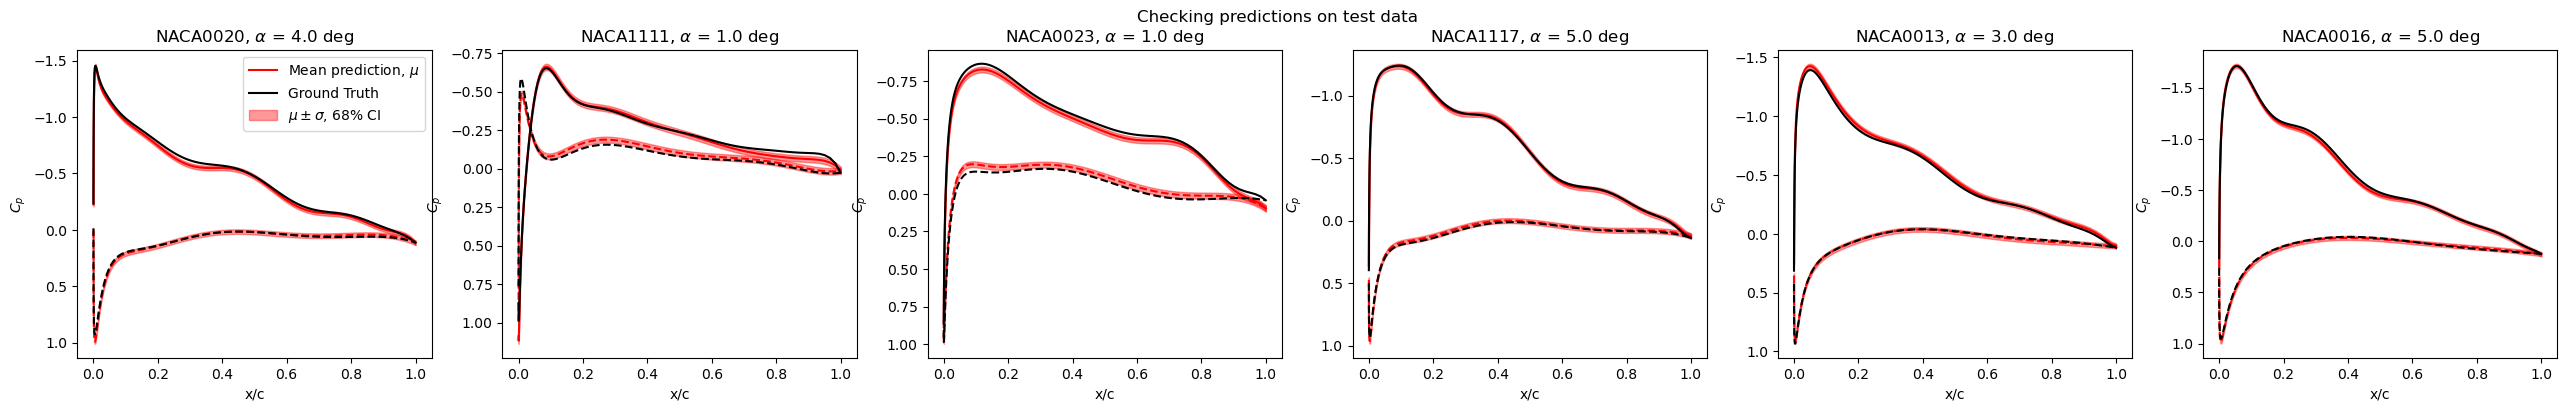

In [178]:
caseIndex = 2

trainPerc = 0.7 # Split percentage
oxTrain, oxTest, oyTrain, oyTest = airfoil_train_test_split(x, y, test_size = 1-trainPerc, random_state=831, printChoice=False)

test_curve = bezier2curve(xTest, yTest, xTest_ctrl_pts, 100, bezier_degs)
mean_ctrl_pts = np.mean(np.squeeze(post_pred_test['Y']),axis=0)
std_ctrl_pts = np.std(np.squeeze(post_pred_test['Y']),axis=0)
mean_curve_test = bezier2curve(xTest, mean_ctrl_pts.reshape((-1,post_pred_test['Y'].shape[2])) + yTrainMean, xTest_ctrl_pts, 100, bezier_degs)
mean_curve_std_u = bezier2curve(xTest, mean_ctrl_pts.reshape((-1,post_pred_test['Y'].shape[2])) + yTrainMean + std_ctrl_pts, xTest_ctrl_pts, 100, bezier_degs)
mean_curve_std_l = bezier2curve(xTest, mean_ctrl_pts.reshape((-1,post_pred_test['Y'].shape[2])) + yTrainMean - std_ctrl_pts, xTest_ctrl_pts, 100, bezier_degs)

# Verify fits on the test data 
validation_samples = np.random.choice(np.arange(0, xTest.shape[0]), size=6)
fig, ax = plt.subplots(1,6, figsize=(32,4))
verifyCpResults(validation_samples[0], test_curve, mean_curve_test, mean_curve_std_u, mean_curve_std_l, afTrain, ax, 0)
verifyCpResults(validation_samples[1], test_curve, mean_curve_test, mean_curve_std_u, mean_curve_std_l, afTrain, ax, 1)
verifyCpResults(validation_samples[2], test_curve, mean_curve_test, mean_curve_std_u, mean_curve_std_l, afTrain, ax, 2)
verifyCpResults(validation_samples[3], test_curve, mean_curve_test, mean_curve_std_u, mean_curve_std_l, afTrain, ax, 3)
verifyCpResults(validation_samples[4], test_curve, mean_curve_test, mean_curve_std_u, mean_curve_std_l, afTrain, ax, 4)
verifyCpResults(validation_samples[5], test_curve, mean_curve_test, mean_curve_std_u, mean_curve_std_l, afTrain, ax, 5)
ax[0].legend()
fig.suptitle('Checking predictions on test data')

## Validation on other types of airfoils

Need to do this, only the XFOIL the data is plotted as of now

Case 1: Clark Y

0


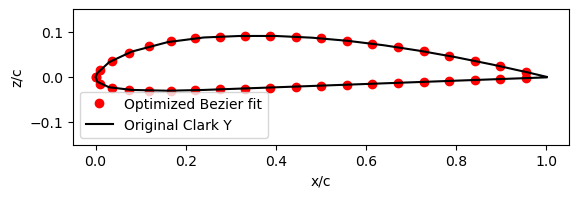

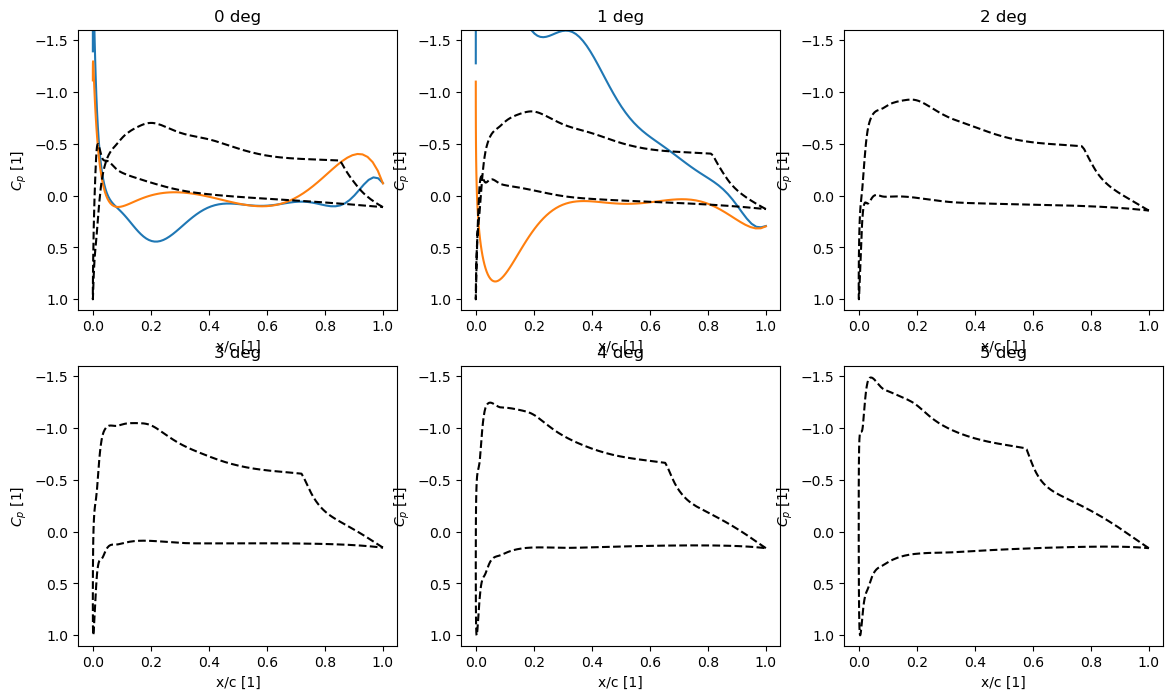

In [179]:
runNew = True
# Read Clark Y Coordinates
if runNew:
    fileLoc = './data/validation_ClarkY/'
    clark_y = np.loadtxt(fileLoc+"clark_y.txt", delimiter=' ')
    num_pts = clark_y.shape[0]
    clark_y_rs = np.hstack((clark_y.reshape((1,-1), order='F'), np.array([1])[:,None])) # Append a single num for the function
    case1, dummy_y, new_ctrl_pts = convert_bezier(clark_y_rs, np.zeros((1, num_pts)), bezier_degs)

plt.figure()
clark_y_profile = bezier2curve(case1, dummy_y, new_ctrl_pts, 100, bezier_degs)
plt.plot(clark_y_profile[0]['af_u'][0][::5], clark_y_profile[0]['af_u'][1][::5],'ro', label='Optimized Bezier fit')
plt.plot(clark_y_profile[0]['af_l'][0][::5], clark_y_profile[0]['af_l'][1][::5],'ro')
plt.plot(clark_y[::4,0], clark_y[::4,1], 'k-', label = 'Original Clark Y')
plt.xlabel('x/c')
plt.ylabel('z/c')
plt.axis('scaled')
plt.ylim([-0.15,0.15])
plt.legend()

# Case a) a = 0 deg
f_case1, ax_case1 = plt.subplots(2,3,figsize=(14,8))
case1[-1] = 0 
case1a_results = posterior_predictive(rng_subkey, case1)
case1a_results_mu = np.mean(np.squeeze(case1a_results['Y']), axis=0) + yTrainMean
case1a_results_curve = bezier2curve(case1, case1a_results_mu.reshape((1,-1)), new_ctrl_pts, 100, bezier_degs)
ax_case1[0,0].plot(case1a_results_curve[0]['cp_u'][0], case1a_results_curve[0]['cp_u'][1])
ax_case1[0,0].plot(case1a_results_curve[0]['cp_l'][0], case1a_results_curve[0]['cp_l'][1])

    # Validation data 
case1a_val = np.loadtxt(fileLoc+"clarkY_0.txt", delimiter=' ')
ax_case1[0,0].plot(case1a_val[:,0], case1a_val[:,2],'k--', label='XFOIL')
ax_case1[0,0].set_xlabel('x/c [1]')
ax_case1[0,0].set_ylabel('$C_p$ [1]')
ax_case1[0,0].title.set_text('0 deg')
ax_case1[0,0].set_ylim([-1.6, 1.1])
ax_case1[0,0].invert_yaxis()

# Case b) a = 1 deg
case1[-1] = 1 
case1b_results = posterior_predictive(rng_subkey, case1)
case1b_results_mu = np.mean(np.squeeze(case1b_results['Y']), axis=0) + yTrainMean
case1b_results_curve = bezier2curve(case1, case1b_results_mu.reshape((1,-1)), new_ctrl_pts, 100, bezier_degs)
ax_case1[0,1].plot(case1b_results_curve[0]['cp_u'][0], case1b_results_curve[0]['cp_u'][1])
ax_case1[0,1].plot(case1b_results_curve[0]['cp_l'][0], case1b_results_curve[0]['cp_l'][1])
    # Validation data 
case1b_val = np.loadtxt(fileLoc+"clarkY_1.txt", delimiter=' ')
ax_case1[0,1].plot(case1b_val[:,0], case1b_val[:,2],'k--', label='XFOIL')
ax_case1[0,1].set_xlabel('x/c [1]')
ax_case1[0,1].set_ylabel('$C_p$ [1]')
ax_case1[0,1].title.set_text('1 deg')
ax_case1[0,1].set_ylim([-1.6, 1.1])
ax_case1[0,1].invert_yaxis()

# Case c) a = 2 deg
    # Validation data 
case1c_val = np.loadtxt(fileLoc+"clarkY_2.txt", delimiter=' ')
ax_case1[0,2].plot(case1c_val[:,0], case1c_val[:,2],'k--', label='XFOIL')
ax_case1[0,2].set_xlabel('x/c [1]')
ax_case1[0,2].set_ylabel('$C_p$ [1]')
ax_case1[0,2].title.set_text('2 deg')
ax_case1[0,2].set_ylim([-1.6, 1.1])
ax_case1[0,2].invert_yaxis()

# Case d) a = 3 deg
    # Validation data 
case1d_val = np.loadtxt(fileLoc+"clarkY_3.txt", delimiter=' ')
ax_case1[1,0].plot(case1d_val[:,0], case1d_val[:,2],'k--', label='XFOIL')
ax_case1[1,0].set_xlabel('x/c [1]')
ax_case1[1,0].set_ylabel('$C_p$ [1]')
ax_case1[1,0].title.set_text('3 deg')
ax_case1[1,0].set_ylim([-1.6, 1.1])
ax_case1[1,0].invert_yaxis()

# Case e) a = 4 deg
    # Validation data 
case1e_val = np.loadtxt(fileLoc+"clarkY_4.txt", delimiter=' ')
ax_case1[1,1].plot(case1e_val[:,0], case1e_val[:,2],'k--', label='XFOIL')
ax_case1[1,1].set_xlabel('x/c [1]')
ax_case1[1,1].set_ylabel('$C_p$ [1]')
ax_case1[1,1].title.set_text('4 deg')
ax_case1[1,1].set_ylim([-1.6, 1.1])
ax_case1[1,1].invert_yaxis()

# Case f) a = 5 deg
    # Validation data 
case1f_val = np.loadtxt(fileLoc+"clarkY_5.txt", delimiter=' ')
ax_case1[1,2].plot(case1f_val[:,0], case1f_val[:,2],'k--', label='XFOIL')
ax_case1[1,2].set_xlabel('x/c [1]')
ax_case1[1,2].set_ylabel('$C_p$ [1]')
ax_case1[1,2].title.set_text('5 deg')
ax_case1[1,2].set_ylim([-1.6, 1.1])
ax_case1[1,2].invert_yaxis()

Case 2: Onera D

0


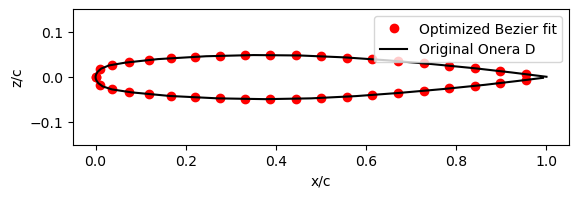

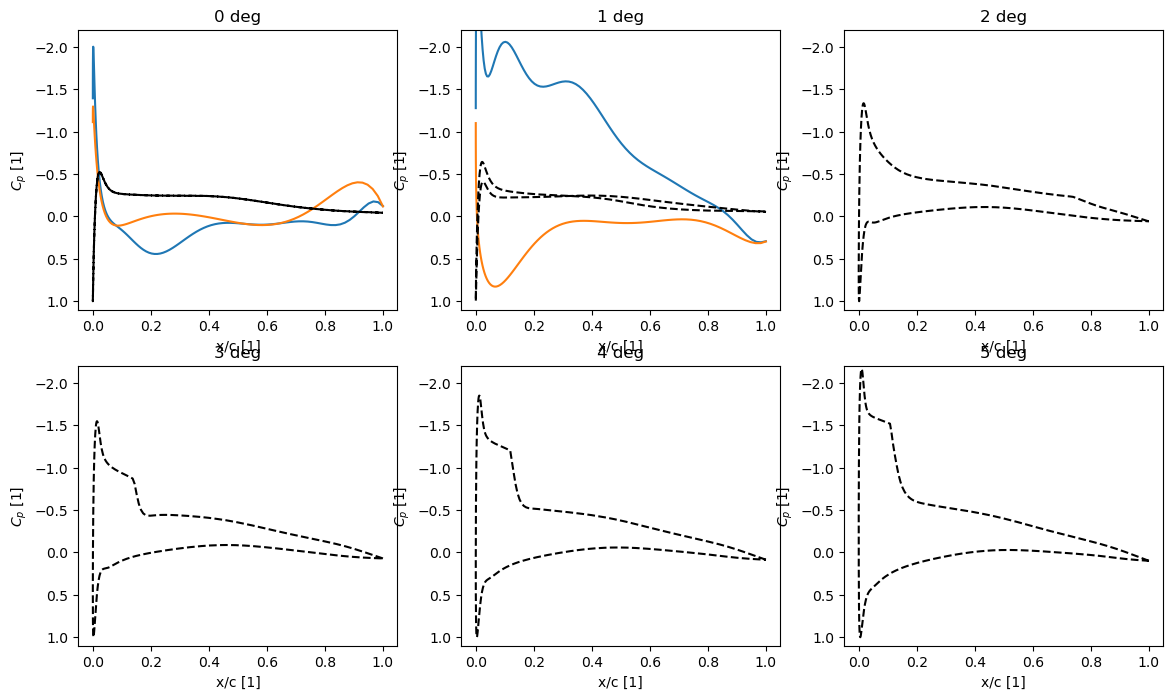

In [139]:
runNew = True
# Read Onera D Coordinates
if runNew:
    fileLoc = './data/validation_OneraD/'
    onera_D = np.loadtxt(fileLoc+"oneraD.txt", delimiter=' ')
    num_pts = onera_D.shape[0]
    onera_D_rs = np.hstack((onera_D.reshape((1,-1), order='F'), np.array([1])[:,None])) # Append a single num for the function
    case2, dummy_y, new_ctrl_pts = convert_bezier(onera_D_rs, np.zeros((1, num_pts)), bezier_degs)

plt.figure()
onera_D_profile = bezier2curve(case2, dummy_y, new_ctrl_pts, 100, bezier_degs)
plt.plot(onera_D_profile[0]['af_u'][0][::5], onera_D_profile[0]['af_u'][1][::5],'ro', label='Optimized Bezier fit')
plt.plot(onera_D_profile[0]['af_l'][0][::5], onera_D_profile[0]['af_l'][1][::5],'ro')
plt.plot(onera_D[::4,0], onera_D[::4,1], 'k-', label = 'Original Onera D')
plt.xlabel('x/c')
plt.ylabel('z/c')
plt.axis('scaled')
plt.ylim([-0.15,0.15])
plt.legend()

# Case a) a = 0 deg
f_case2, ax_case2 = plt.subplots(2,3,figsize=(14,8))
case2[-1] = 0 
case2a_results = posterior_predictive(rng_subkey, case2)
case2a_results_mu = np.mean(np.squeeze(case2a_results['Y']), axis=0) + yTrainMean
case2a_results_curve = bezier2curve(case2, case2a_results_mu.reshape((1,-1)), new_ctrl_pts, 100, bezier_degs)
ax_case2[0,0].plot(case2a_results_curve[0]['cp_u'][0], case2a_results_curve[0]['cp_u'][1])
ax_case2[0,0].plot(case2a_results_curve[0]['cp_l'][0], case2a_results_curve[0]['cp_l'][1])

    # Validation data 
case2a_val = np.loadtxt(fileLoc+"oneraD_0.txt", delimiter=' ')
ax_case2[0,0].plot(case2a_val[:,0], case2a_val[:,2],'k--', label='XFOIL')
ax_case2[0,0].set_xlabel('x/c [1]')
ax_case2[0,0].set_ylabel('$C_p$ [1]')
ax_case2[0,0].title.set_text('0 deg')
ax_case2[0,0].set_ylim([-2.2, 1.1])
ax_case2[0,0].invert_yaxis()

# Case b) a = 1 deg
case2[-1] = 1 
case2b_results = posterior_predictive(rng_subkey, case2)
case2b_results_mu = np.mean(np.squeeze(case2b_results['Y']), axis=0) + yTrainMean
case2b_results_curve = bezier2curve(case2, case2b_results_mu.reshape((1,-1)), new_ctrl_pts, 100, bezier_degs)
ax_case2[0,1].plot(case2b_results_curve[0]['cp_u'][0], case2b_results_curve[0]['cp_u'][1])
ax_case2[0,1].plot(case2b_results_curve[0]['cp_l'][0], case2b_results_curve[0]['cp_l'][1])
    # Validation data 
case2b_val = np.loadtxt(fileLoc+"oneraD_1.txt", delimiter=' ')
ax_case2[0,1].plot(case2b_val[:,0], case2b_val[:,2],'k--', label='XFOIL')
ax_case2[0,1].set_xlabel('x/c [1]')
ax_case2[0,1].set_ylabel('$C_p$ [1]')
ax_case2[0,1].title.set_text('1 deg')
ax_case2[0,1].set_ylim([-2.2, 1.1])
ax_case2[0,1].invert_yaxis()

# Case c) a = 2 deg
    # Validation data 
case2c_val = np.loadtxt(fileLoc+"oneraD_2.txt", delimiter=' ')
ax_case2[0,2].plot(case2c_val[:,0], case2c_val[:,2],'k--', label='XFOIL')
ax_case2[0,2].set_xlabel('x/c [1]')
ax_case2[0,2].set_ylabel('$C_p$ [1]')
ax_case2[0,2].title.set_text('2 deg')
ax_case2[0,2].set_ylim([-2.2, 1.1])
ax_case2[0,2].invert_yaxis()

# Case d) a = 3 deg
    # Validation data 
case2d_val = np.loadtxt(fileLoc+"oneraD_3.txt", delimiter=' ')
ax_case2[1,0].plot(case2d_val[:,0], case2d_val[:,2],'k--', label='XFOIL')
ax_case2[1,0].set_xlabel('x/c [1]')
ax_case2[1,0].set_ylabel('$C_p$ [1]')
ax_case2[1,0].title.set_text('3 deg')
ax_case2[1,0].set_ylim([-2.2, 1.1])
ax_case2[1,0].invert_yaxis()

# Case e) a = 4 deg
    # Validation data 
case2e_val = np.loadtxt(fileLoc+"oneraD_4.txt", delimiter=' ')
ax_case2[1,1].plot(case2e_val[:,0], case2e_val[:,2],'k--', label='XFOIL')
ax_case2[1,1].set_xlabel('x/c [1]')
ax_case2[1,1].set_ylabel('$C_p$ [1]')
ax_case2[1,1].title.set_text('4 deg')
ax_case2[1,1].set_ylim([-2.2, 1.1])
ax_case2[1,1].invert_yaxis()

# Case f) a = 5 deg
    # Validation data 
case2f_val = np.loadtxt(fileLoc+"oneraD_5.txt", delimiter=' ')
ax_case2[1,2].plot(case2f_val[:,0], case2f_val[:,2],'k--', label='XFOIL')
ax_case2[1,2].set_xlabel('x/c [1]')
ax_case2[1,2].set_ylabel('$C_p$ [1]')
ax_case2[1,2].title.set_text('5 deg')
ax_case2[1,2].set_ylim([-2.2, 1.1])
ax_case2[1,2].invert_yaxis()